In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 27 Lecture 1 Assignment

In this assignment, we will learn statistical significance in linear models. We will use the google play store dataset loaded below and analyze the regression from this dataset.

In [2]:
import warnings
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
reviews = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv"
)

<IPython.core.display.Javascript object>

In [5]:
reviews.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


<IPython.core.display.Javascript object>

We will predict app ratings using other features describing the app. To use these features, we must clean the data.

To simplify, we will remove the app, category, size, installs, genres, last updated, current ver, and android ver columns. 

In [6]:
reviews["Type"].value_counts()

Free    10039
Paid      800
0           1
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
drop_cols = [
    "App",
    "Category",
    "Size",
    "Installs",
    "Genres",
    "Last Updated",
    "Current Ver",
    "Android Ver",
]

reviews = reviews.drop(columns=drop_cols)
reviews.head(2)

,Rating,Reviews,Type,Price,Content Rating
0,4.1,159,Free,0,Everyone
1,3.9,967,Free,0,Everyone


<IPython.core.display.Javascript object>

Check for missing values and remove all rows containing missing values

In [8]:
reviews.isna().mean()

Rating            0.135965
Reviews           0.000000
Type              0.000092
Price             0.000000
Content Rating    0.000092
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
reviews = reviews.dropna()
reviews.shape

(9366, 5)

<IPython.core.display.Javascript object>

In [10]:
reviews["Type"].value_counts()

Free    8719
Paid     647
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

Finally, check that all the columns are of numeric type and change the type of columns that are not numeric. If coercing to numeric causes missing values, remove those rows containing missing values from our dataset.

In [11]:
reviews["Price"] = reviews["Price"].str.strip("$")
reviews["Price"] = pd.to_numeric(reviews["Price"])

<IPython.core.display.Javascript object>

In [12]:
reviews["Reviews"] = pd.to_numeric(reviews["Reviews"])

<IPython.core.display.Javascript object>

Remove outliers from the Type and Content Rating columns (very rare values that won't train well).

Convert the Type and Content Rating columns to a numeric format, whether by one-hot encoding, ordinal encoding, or similar.

In [13]:
reviews["is_free"] = reviews["Type"] == "Free"
reviews["is_free"] = reviews["is_free"].astype(int)
reviews = reviews.drop(columns="Type")
reviews.head(2)

,Rating,Reviews,Price,Content Rating,is_free
0,4.1,159,0.0,Everyone,1
1,3.9,967,0.0,Everyone,1


<IPython.core.display.Javascript object>

In [14]:
# Drop infrequent categories
reviews = reviews[~reviews["Content Rating"].isin(["Adults only 18+", "Unrated"])]
reviews["Content Rating"].value_counts()

Everyone        7420
Teen            1084
Mature 17+       461
Everyone 10+     397
Name: Content Rating, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
content_rating_map = {"Everyone": 0, "Everyone 10+": 1, "Teen": 2, "Mature 17+": 3}
reviews["Content Rating"] = reviews["Content Rating"].replace(content_rating_map)
reviews.head(2)

,Rating,Reviews,Price,Content Rating,is_free
0,4.1,159,0.0,0,1
1,3.9,967,0.0,0,1


<IPython.core.display.Javascript object>

In [16]:
reviews.dtypes

Rating            float64
Reviews             int64
Price             float64
Content Rating      int64
is_free             int64
dtype: object

<IPython.core.display.Javascript object>

Visualize

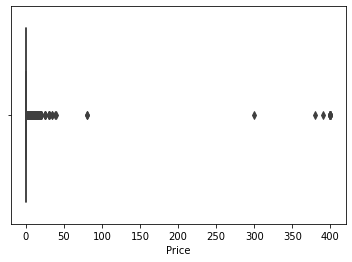

<IPython.core.display.Javascript object>

In [17]:
sns.boxplot(reviews["Price"])
plt.show()

In [18]:
# Dropping high price apps (out of scope of projects interest in typical app behavior)
reviews = reviews[reviews["Price"] < 50]

<IPython.core.display.Javascript object>

In [19]:
# sns.pairplot(reviews)
# plt.show()

<IPython.core.display.Javascript object>

Perform a train test split with 20% of the data in the test sample.

In [20]:
X = reviews.drop(columns="Rating")
y = reviews["Rating"]

<IPython.core.display.Javascript object>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

Now generate a linear model using statsmodels and produce a p value for each coefficient in the model. Analyze the results. (Look at the results table and at a homoscedasticity plot.)

In [22]:
print_vif(X_train)

VIF results
-------------------------------
const             26.897010
Reviews            1.005164
Price              1.748044
Content Rating     1.005289
is_free            1.752503
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [23]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     15.52
Date:                Tue, 01 Sep 2020   Prob (F-statistic):           1.19e-12
Time:                        09:13:55   Log-Likelihood:                -5599.6
No. Observations:                7476   AIC:                         1.121e+04
Df Residuals:                    7471   BIC:                         1.124e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.3177      0.031    140.615      0.000       4.257       4.378
Reviews         1.192e-08   1.89e-09      6.317      0.000    8.22e-09    1.56e-08
Price             -0.0043      0.004     -0.987      0.323      -0.013       0.004
Content Rating    -0.0014      0.007     -0.207      0.836      -0.015       0.012
is_free           -0.1355      0.031     -4.327      0.000      -0.197      -0.074
==============================================================================
Omnibus:                     2961.868   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15226.759
Skew:                          -1.854   Prob(JB):                         0.00
Kurtosis:                       8.927   Cond. No.                     2.35e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

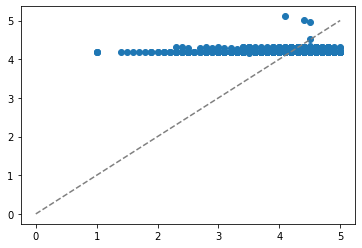

<IPython.core.display.Javascript object>

In [24]:
y_pred = model.predict(X_test_const)

plt.scatter(y_test, y_pred)
plt.plot([0, 5], [0, 5], "--", c="gray")
plt.show()

Scale your predictors and refit the linear model.

* How does this change the coefficients?
* How does this change the coefficients' p values?
* How does this change model performance?

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [26]:
X_train_scl = pd.DataFrame(X_train_scl, columns=X_train.columns, index=X_train.index)
X_test_scl = pd.DataFrame(X_test_scl, columns=X_test.columns, index=X_test.index)

<IPython.core.display.Javascript object>

In [27]:
X_train_const = sm.add_constant(X_train_scl)
X_test_const = sm.add_constant(X_test_scl)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     15.52
Date:                Tue, 01 Sep 2020   Prob (F-statistic):           1.19e-12
Time:                        09:13:55   Log-Likelihood:                -5599.6
No. Observations:                7476   AIC:                         1.121e+04
Df Residuals:                    7471   BIC:                         1.124e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.1956      0.006    708.652      0.000       4.184       4.207
Reviews            0.0375      0.006      6.317      0.000       0.026       0.049
Price             -0.0077      0.008     -0.987      0.323      -0.023       0.008
Content Rating    -0.0012      0.006     -0.207      0.836      -0.013       0.010
is_free           -0.0339      0.008     -4.327      0.000      -0.049      -0.019
==============================================================================
Omnibus:                     2961.868   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15226.759
Skew:                          -1.854   Prob(JB):                         0.00
Kurtosis:                       8.927   Cond. No.                         2.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

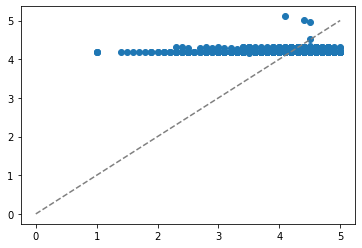

<IPython.core.display.Javascript object>

In [28]:
y_pred = model.predict(X_test_const)

plt.scatter(y_test, y_pred)
plt.plot([0, 5], [0, 5], "--", c="gray")
plt.show()

Investigating transforming skewed inputs

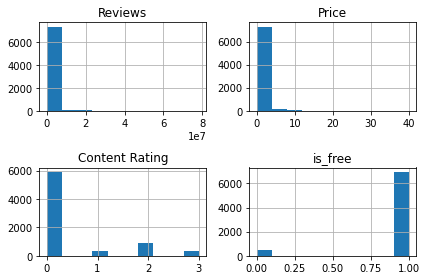

<IPython.core.display.Javascript object>

In [29]:
X_train.hist()
plt.tight_layout()
plt.show()

In [30]:
X_train.loc[:, "Reviews"] = np.log(X_train["Reviews"])
X_test.loc[:, "Reviews"] = np.log(X_test["Reviews"])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<IPython.core.display.Javascript object>

In [31]:
X_train.loc[:, "Price"] = np.log(X_train["Price"] + 1)
X_test.loc[:, "Price"] = np.log(X_test["Price"] + 1)

<IPython.core.display.Javascript object>

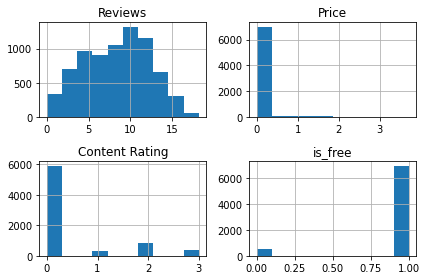

<IPython.core.display.Javascript object>

In [32]:
X_train.hist()
plt.tight_layout()
plt.show()

In [33]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     107.0
Date:                Tue, 01 Sep 2020   Prob (F-statistic):           7.96e-89
Time:                        09:13:57   Log-Likelihood:                -5422.2
No. Observations:                7476   AIC:                         1.085e+04
Df Residuals:                    7471   BIC:                         1.089e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.1840      0.059     71.014      0.000       4.068       4.299
Reviews            0.0307      0.002     20.127      0.000       0.028       0.034
Price             -0.0391      0.036     -1.086      0.278      -0.110       0.031
Content Rating    -0.0187      0.007     -2.798      0.005      -0.032      -0.006
is_free           -0.2510      0.059     -4.263      0.000      -0.366      -0.136
==============================================================================
Omnibus:                     2281.797   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10428.951
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                       8.043   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

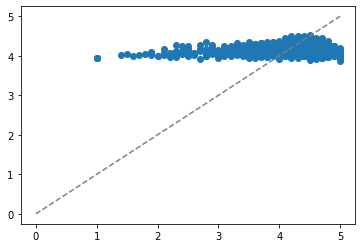

<IPython.core.display.Javascript object>

In [34]:
y_pred = model.predict(X_test_const)

plt.scatter(y_test, y_pred)
plt.plot([0, 5], [0, 5], "--", c="gray")
plt.show()